In [109]:
import os
import uuid
import shutil
#import pylatex
import pandas as pd
import lightkurve as lk 
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable

from datetime import datetime
from tqdm.notebook import tqdm
from multiprocessing import cpu_count, Pool
#from pylatex.section import Chapter, Subsection
#from pylatex import Document, Section, Figure, NoEscape, Command

%run pipeline.ipynb

import warnings
warnings.filterwarnings("ignore")

In [2]:
pd.options.display.max_columns = None

In [111]:
mylc=get_lc_string('TIC-59129133-43-SPOC-120')
mylc2=get_lc_string('TIC-59129133-5-FFI-30min')
mylc3=get_lc_string('EPIC-246676629-13-EVEREST-1800')

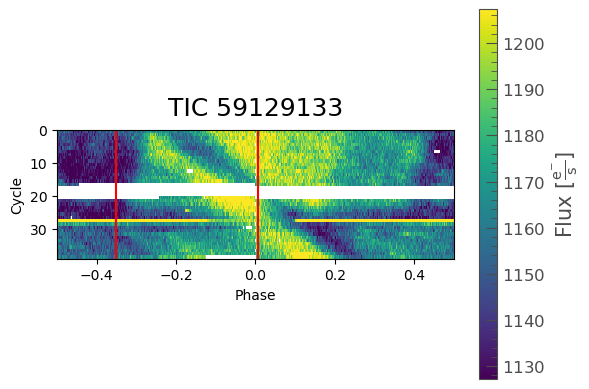

In [4]:
river_plot(mylc)

In [5]:
# def subgraph_rp(lc, epoch_time=None, period=None, ax=None, normalize=True):
#     fig = None
    
#     if period == None:
#         period = lc.to_periodogram(maximum_period=5).period_at_max_power
#     if epoch_time == None:
#         epoch_time = lc.time[0]
#     if normalize:
#         lc=lc.normalize()

#     lc = lc.fold(period, epoch_time=epoch_time)    
#     blc = lc.bin(u.Quantity(period/200, u.d))
#     blc.sort("flux")

#     min = blc[0][0].value/lc.period.value
#     max = blc[-1][0].value/lc.period.value

#     if ax == None:
#         fig, ax = plt.subplots()
    
#     lc.plot_river(ax=ax)
    
#     ax.axvline(min, 0, 1, color="red")
#     ax.axvline(max, 0, 1, color="red")
    
#     if fig != None:
#         return fig

In [6]:
#exact version from the documentation
def plot_river(
        self,
        period,
        epoch_time=None,
        ax=None,
        bin_points=1,
        minimum_phase=-0.5,
        maximum_phase=0.5,
        method="mean",
        **kwargs,
    ) -> matplotlib.axes.Axes:
        """Plot the light curve as a river plot.

        A river plot uses colors to represent the light curve values in
        chronological order, relative to the period of an interesting signal.
        Each row in the plot represents a full period cycle, and each column
        represents a fixed phase.  This type of plot is often used to visualize
        Transit Timing Variations (TTVs) in the light curves of exoplanets, but
        it can be used to visualize periodic signals of any origin.

        All extra keywords supplied are passed on to Matplotlib's
        `~matplotlib.pyplot.pcolormesh` function.

        Parameters
        ----------
        ax : `~matplotlib.axes.Axes`
            The matplotlib axes object.
        period: float
            Period at which to fold the light curve
        epoch_time : float
            Phase mid point for plotting. Defaults to the first time value.
        bin_points : int
            How many points should be in each bin.
        minimum_phase : float
            The minimum phase to plot.
        maximum_phase : float
            The maximum phase to plot.
        method : str
            The river method. Choose from `'mean'` or `'median'` or `'sigma'`.
            If `'mean'` or `'median'`, the plot will display the average value in each bin.
            If `'sigma'`, the plot will display the average in the bin divided by
            the error in each bin, in order to show the data in terms of standard
            deviation.
        kwargs : dict
            Dictionary of arguments to be passed on to Matplotlib's
            `~matplotlib.pyplot.pcolormesh` function.

        Returns
        -------
        ax : `~matplotlib.axes.Axes`
            The matplotlib axes object.
        """
        if hasattr(self, "time_original"):  # folded light curve
            time = self.time_original
        else:
            time = self.time

        # epoch_time defaults to the first time value
        if epoch_time is None:
            epoch_time = time[0]

        # Lightkurve v1.x assumed that `period` was given in days if no unit
        # was specified.  We maintain this behavior for backwards-compatibility.
        if period is not None and not isinstance(period, Quantity):
            period *= u.day
        if epoch_time is not None and not isinstance(epoch_time, (Time, Quantity)):
            epoch_time = Time(epoch_time, format=time.format, scale=time.scale)

        method = validate_method(method, supported_methods=["mean", "median", "sigma"])
        if (bin_points == 1) and (method in ["mean", "median"]):
            bin_func = lambda y, e: (y[0], e[0])
        elif (bin_points == 1) and (method in ["sigma"]):
            bin_func = lambda y, e: ((y[0] - 1) / e[0], np.nan)
        elif method == "mean":
            bin_func = lambda y, e: (np.nanmean(y), np.nansum(e**2) ** 0.5 / len(e))
        elif method == "median":
            bin_func = lambda y, e: (np.nanmedian(y), np.nansum(e**2) ** 0.5 / len(e))
        elif method == "sigma":
            bin_func = lambda y, e: (
                (np.nanmean(y) - 1) / (np.nansum(e**2) ** 0.5 / len(e)),
                np.nan,
            )

        s = np.argsort(time.value)
        x, y, e = time.value[s], self.flux[s], self.flux_err[s]
        med = np.nanmedian(self.flux)
        e /= med
        y /= med

        # Here `ph` is the phase of each time point x
        # cyc is the number of cycles that have occurred at each time point x
        # since the phase 0 before x[0]
        n = int(
            period.value
            / np.nanmedian(np.diff(x))
            * (maximum_phase - minimum_phase)
            / bin_points
        )
        if n == 1:
            bin_points = int(maximum_phase - minimum_phase) / (
                2 / int(period.value / np.nanmedian(np.diff(x)))
            )
            warnings.warn(
                "`bin_points` is too high to plot a phase curve, resetting to {}".format(
                    bin_points
                ),
                LightkurveWarning,
            )
            n = 2
        ph = x / period.value % 1
        cyc = np.asarray((x - x % period.value) / period.value, int)
        cyc -= np.min(cyc)

        phase = (epoch_time.value % period.value) / period.value
        ph = ((x - (phase * period.value)) / period.value) % 1
        cyc = np.asarray(
            (x - ((x - phase * period.value) % period.value)) / period.value, int
        )
        cyc -= np.min(cyc)
        ph[ph > 0.5] -= 1

        ar = np.empty((n, np.max(cyc) + 1))
        ar[:] = np.nan
        bs = np.linspace(minimum_phase, maximum_phase, n + 1)
        cycs = np.arange(0, np.max(cyc) + 2)

        ph_masks = [(ph > bs[jdx]) & (ph <= bs[jdx + 1]) for jdx in range(n)]
        qual_mask = np.isfinite(y)
        for cyc1 in np.unique(cyc):
            cyc_mask = cyc == cyc1
            if not np.any(cyc_mask):
                continue
            for jdx, ph_mask in enumerate(ph_masks):
                if not np.any(cyc_mask & ph_mask & qual_mask):
                    ar[jdx, cyc1] = np.nan
                else:
                    ar[jdx, cyc1] = bin_func(
                        y[cyc_mask & ph_mask], e[cyc_mask & ph_mask]
                    )[0]

        # If the method is average we need to denormalize the plot
        if method in ["mean", "median"]:
            median = np.nanmedian(self.flux.value)
            if hasattr(median, "mask"):
                median = median.filled(np.nan)
            ar *= median

        d = np.max(
            [
                np.abs(np.nanmedian(ar) - np.nanpercentile(ar, 5)),
                np.abs(np.nanmedian(ar) - np.nanpercentile(ar, 95)),
            ]
        )
        vmin = kwargs.pop("vmin", np.nanmedian(ar) - d)
        vmax = kwargs.pop("vmax", np.nanmedian(ar) + d)
        if method in ["mean", "median"]:
            cmap = kwargs.pop("cmap", "viridis")
        elif method == "sigma":
            cmap = kwargs.pop("cmap", "coolwarm")

        with plt.style.context(MPLSTYLE):
            if ax is None:
                _, ax = plt.subplots(figsize=(12, cyc.max() * 0.1))

            im = ax.pcolormesh(
                bs, cycs, ar.T, vmin=vmin, vmax=vmax, cmap=cmap, **kwargs
            )
            cbar = plt.colorbar(im, ax=ax)
            if method in ["mean", "median"]:
                unit = "[Normalized Flux]"
                if self.flux.unit is not None:
                    if self.flux.unit != u.dimensionless_unscaled:
                        unit = "[{}]".format(self.flux.unit.to_string("latex"))
                if bin_points == 1:
                    cbar.set_label("Flux {}".format(unit))
                else:
                    cbar.set_label("Average Flux in Bin {}".format(unit))
            elif method == "sigma":
                if bin_points == 1:
                    cbar.set_label(
                        "Flux in units of Standard Deviation "
                        r"$(f - \overline{f})/(\sigma_f)$"
                    )
                else:
                    cbar.set_label(
                        "Average Flux in Bin in units of Standard Deviation "
                        r"$(f - \overline{f})/(\sigma_f)$"
                    )

            ax.set_xlabel("Phase")
            ax.set_ylabel("Cycle")
            ax.set_ylim(cyc.max(), 0)
            ax.set_title(self.meta.get("LABEL"))
            a = cyc.max() * 0.1 / 12.0
            b = (cyc.max() - cyc.min()) / (bs.max() - bs.min())
            ax.set_aspect(a / b)
        return ax

In [7]:
myperiod=mylc.to_periodogram(maximum_period=5).period_at_max_power

In [8]:
u.Quantity(myperiod,u.s)

<Quantity 54169.81060915 s>

In [9]:
u.Quantity(myperiod/200,u.s)

<Quantity 270.84905305 s>

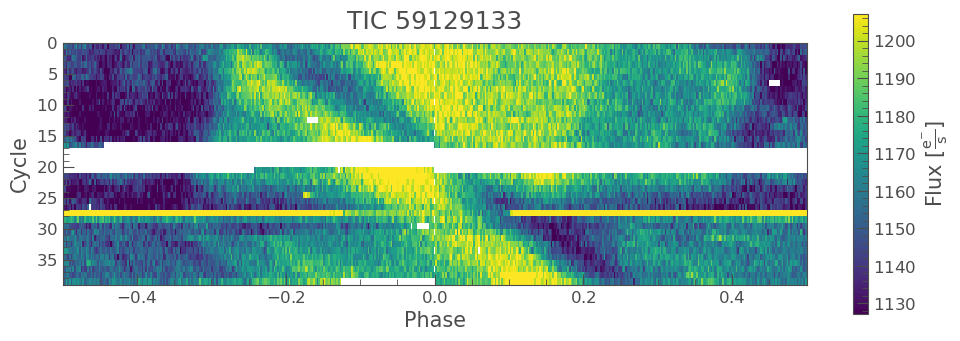

In [10]:
plt.close('all')
ax=mylc.plot_river(period=myperiod)
plt.show()

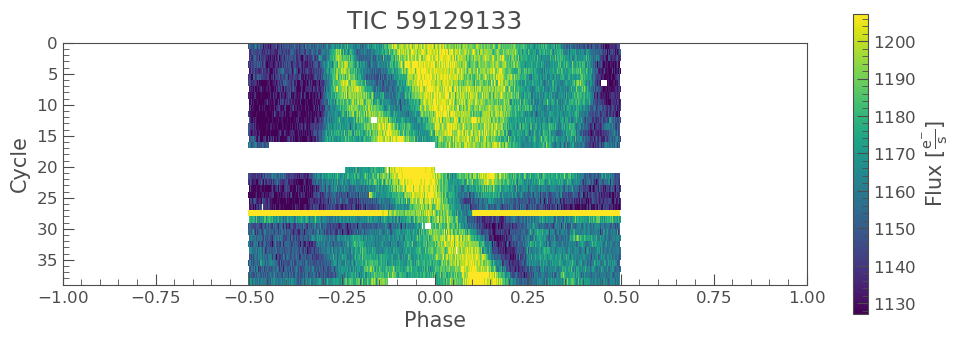

In [11]:
plt.close('all')
ax=mylc.plot_river(period=myperiod, minimum_phase=-1, maximum_phase=1)
plt.show()

In [12]:
# def subgraph_rp(
#         lc,
#         period=None,
#         epoch_time=None,
#         ax=None,
#         bin_points=1,
#         minimum_phase=-0.5,
#         maximum_phase=0.5,
#         method="mean",
#         normalize=True,
#         **kwargs,
#     ) -> matplotlib.axes.Axes:

#         fig = None
    
#         if hasattr(lc, "time_original"):  # folded light curve
#             time = lc.time_original
#         else:
#             time = lc.time

#         if period == None:
#             period = lc.to_periodogram(maximum_period=5).period_at_max_power
#         if epoch_time == None:
#             epoch_time = lc.time[0]
#         if normalize:
#             lc=lc.normalize()

#         foldedlc = lc.fold(period, epoch_time=epoch_time) 
#         blc = foldedlc.bin(u.Quantity(period/200, u.d))
#         blc.sort("flux")
#         min = blc[0][0].value/foldedlc.period.value
#         max = blc[-1][0].value/foldedlc.period.value

#         if (bin_points == 1) and (method in ["mean", "median"]):
#             bin_func = lambda y, e: (y[0], e[0])
#         elif method == "mean":
#             bin_func = lambda y, e: (np.nanmean(y), np.nansum(e**2) ** 0.5 / len(e))

#         s = np.argsort(time.value)
#         x, y, e = time.value[s], lc.flux[s], lc.flux_err[s]
#         med = np.nanmedian(lc.flux)
#         e /= med
#         y /= med

#         # Here `ph` is the phase of each time point x
#         # cyc is the number of cycles that have occurred at each time point x
#         # since the phase 0 before x[0]
#         n = int(
#             period.value
#             / np.nanmedian(np.diff(x))
#             * (maximum_phase - minimum_phase)
#             / bin_points
#         )
#         if n == 1:
#             bin_points = int(maximum_phase - minimum_phase) / (
#                 2 / int(period.value / np.nanmedian(np.diff(x)))
#             )
#             warnings.warn(
#                 "`bin_points` is too high to plot a phase curve, resetting to {}".format(
#                     bin_points
#                 ),
#                 LightkurveWarning,
#             )
#             n = 2
#         ph = x / period.value % 1
#         cyc = np.asarray((x - x % period.value) / period.value, int)
#         cyc -= np.min(cyc)

#         phase = (epoch_time.value % period.value) / period.value
#         ph = ((x - (phase * period.value)) / period.value) % 1
#         cyc = np.asarray(
#             (x - ((x - phase * period.value) % period.value)) / period.value, int
#         )
#         cyc -= np.min(cyc)
#         ph[ph > 0.5] -= 1

#         ar = np.empty((n, np.max(cyc) + 1))
#         ar[:] = np.nan
#         bs = np.linspace(minimum_phase, maximum_phase, n + 1)
#         cycs = np.arange(0, np.max(cyc) + 2)

#         ph_masks = [(ph > bs[jdx]) & (ph <= bs[jdx + 1]) for jdx in range(n)]
#         qual_mask = np.isfinite(y)
#         for cyc1 in np.unique(cyc):
#             cyc_mask = cyc == cyc1
#             if not np.any(cyc_mask):
#                 continue
#             for jdx, ph_mask in enumerate(ph_masks):
#                 if not np.any(cyc_mask & ph_mask & qual_mask):
#                     ar[jdx, cyc1] = np.nan
#                 else:
#                     ar[jdx, cyc1] = bin_func(
#                         y[cyc_mask & ph_mask], e[cyc_mask & ph_mask]
#                     )[0]

    
#         # If the method is average we need to denormalize the plot
#         if method in ["mean", "median"]:
#             median = np.nanmedian(lc.flux.value)
#             if hasattr(median, "mask"):
#                 median = median.filled(np.nan)
#             ar *= median

#         d = np.max(
#             [
#                 np.abs(np.nanmedian(ar) - np.nanpercentile(ar, 5)),
#                 np.abs(np.nanmedian(ar) - np.nanpercentile(ar, 95)),
#             ]
#         )
#         vmin = kwargs.pop("vmin", np.nanmedian(ar) - d)
#         vmax = kwargs.pop("vmax", np.nanmedian(ar) + d)
#         if method in ["mean", "median"]:
#             cmap = kwargs.pop("cmap", "viridis")

#         with plt.style.context("seaborn-v0_8-paper"):
#             if ax == None:
#                 fig, ax = plt.subplots(figsize=(12, cyc.max() * 0.1))
#             # if ax is None:
#             #     _, ax = plt.subplots(figsize=(12, cyc.max() * 0.1))

#             im = ax.pcolormesh(
#                 bs, cycs, ar.T, vmin=vmin, vmax=vmax, cmap=cmap, **kwargs
#             )
#             cbar = plt.colorbar(im, ax=ax)

#             ax.axvline(min, 0, 1, color="red")
#             ax.axvline(max, 0, 1, color="red")
            
#             if method in ["mean", "median"]:
#                 unit = "[Normalized Flux]"
#                 if lc.flux.unit is not None:
#                     if lc.flux.unit != u.dimensionless_unscaled:
#                         unit = "[{}]".format(lc.flux.unit.to_string("latex"))
#                 if bin_points == 1:
#                     cbar.set_label("Normalized Flux")
#                 else:
#                     cbar.set_label("Average Flux in Bin {}".format(unit))

#             ax.set_xlabel("Phase")
#             ax.set_ylabel("Cycle")
#             ax.set_ylim(cyc.max(), 0)
#             a = cyc.max() * 0.1 / 12.0
#             b = (cyc.max() - cyc.min()) / (bs.max() - bs.min())
#             ax.set_aspect(a / b)
            
#         if fig != None:
#             return fig

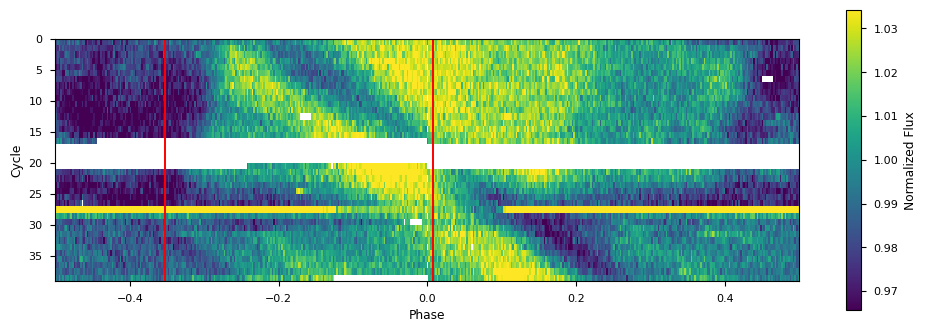

In [13]:
subgraph_rp(lc=mylc)

In [113]:
gaiatable=pd.read_csv('makingtable/cleanedgaiadata.csv')

In [15]:
gaiatable

pop_id  TIC  gaiadr3_source_id  epic_id  per group  age_Myr  \
0          NaN  NaN                NaN      NaN  NaN   NaN      NaN   
1          NaN  NaN                NaN      NaN  NaN   NaN      NaN   
2          NaN  NaN                NaN      NaN  NaN   NaN      NaN   
3          NaN  NaN                NaN      NaN  NaN   NaN      NaN   
4          NaN  NaN                NaN      NaN  NaN   NaN      NaN   
...        ...  ...                ...      ...  ...   ...      ...   
289027     NaN  NaN                NaN      NaN  NaN   NaN      NaN   
289028     NaN  NaN                NaN      NaN  NaN   NaN      NaN   
289029     NaN  NaN                NaN      NaN  NaN   NaN      NaN   
289030     NaN  NaN                NaN      NaN  NaN   NaN      NaN   
289031     NaN  NaN                NaN      NaN  NaN   NaN      NaN   

       disco_paper author  year          solution_id  \
0              NaN    NaN   NaN  1636148068921376768   
1              NaN    NaN   NaN  1636148068921376768   
2              NaN    NaN   NaN  1636148068921376768   
3              NaN    NaN   NaN  1636148068921376768   
4              NaN    NaN   NaN  1636148068921376768   
...            ...    ...   ...                  ...   
289027         NaN    NaN   NaN  1636148068921376768   
289028         NaN    NaN   NaN  1636148068921376768   
289029         NaN    NaN   NaN  1636148068921376768   
289030         NaN    NaN   NaN  1636148068921376768   
289031         NaN    NaN   NaN  1636148068921376768   

                         designation            source_id  random_index  \
0       Gaia DR3 5779294666219437312  5779294666219437312      78771632   
1       Gaia DR3 5578150627507774976  5578150627507774976     178136786   
2       Gaia DR3 1732715808663042176  1732715808663042176    1409634765   
3       Gaia DR3 1733782571164433408  1733782571164433408    1410169022   
4       Gaia DR3 1733786836067830784  1733786836067830784     340712339   
...                              ...                  ...           ...   
289027  Gaia DR3 5580934556589041024  5580934556589041024     648469238   
289028  Gaia DR3 5580935930978162688  5580935930978162688    1792972530   
289029  Gaia DR3 5578143755560164736  5578143755560164736    1506613867   
289030  Gaia DR3 5779975092120931840  5779975092120931840    1623614978   
289031  Gaia DR3 5779293394908681984  5779293394908681984     347188960   

        ref_epoch          ra  ra_error        dec  dec_error   parallax  \
0          2016.0  232.815637  0.070653 -78.966974   0.068942  12.299565   
1          2016.0  103.967005  0.011498 -36.817295   0.013427  11.498548   
2          2016.0  318.669928  0.017616   5.500387   0.015705  13.831532   
3          2016.0  318.242204  0.039658   6.372225   0.044913  17.403268   
4          2016.0  318.061324  0.021013   6.483088   0.019751  11.401466   
...           ...         ...       ...        ...        ...        ...   
289027     2016.0   98.974095  0.027865 -35.250911   0.030382  10.458252   
289028     2016.0   98.998461  0.024596 -35.171446   0.027114  13.122792   
289029     2016.0  104.165119  0.044121 -36.841157   0.044331  12.807492   
289030     2016.0  238.019941  0.032159 -77.080600   0.034338  11.138560   
289031     2016.0  233.104563  0.039552 -79.006788   0.038846  12.911832   

        parallax_error  parallax_over_error          pm        pmra  \
0             0.080748            152.32100   70.564330  -40.948589   
1             0.013905            826.93536   90.030480  -47.745765   
2             0.020791            665.25830   55.659027   41.192252   
3             0.050613            343.85090   72.336700  -50.726373   
4             0.027471            415.04102  178.431880  176.884402   
...                ...                  ...         ...         ...   
289027        0.035381            295.59042   66.424370   17.908199   
289028        0.031437            417.43620   71.720810   48.445070   
289029        0.050231       

In [16]:
ninety=np.percentile(mylc['flux'],90)
ten=np.percentile(mylc['flux'],10)
amplitude=ninety-ten

List of facts to include:
- TIC 
- GDR3
- EPIC
- Sector or campaign
- Cadence
- Discovery info
- Ra and dec 
- Absolute G, RP, bp
- G-RP
- RUWE
- Parallax
- Distance
- Age
- Group
- Amplitude - 90% flux to 10% flux value

In [18]:
# def subgraph_text(lc, infostring, gaiatable, ax=None):
#     #gaiatable must be a dataframe. load it in the multiplot fn
#     fig = None
    
#     parts=infostring.split("-")
#     id_type=parts[0]
#     starid=float(parts[1])
#     secorcamp=parts[2]
#     author=parts[3]
#     exptime=parts[4]
    
#     if ax == None:
#         fig, ax = plt.subplots()

#     if id_type=='TIC':
#         secorcampname='Sector'
#         gaiarow=gaiatable[gaiatable.TIC==starid]
#     elif id_type=='EPIC':
#         secorcampname='Campaign'
#         gaiarow=gaiatable[gaiatable.epic_id==starid]

#     ninety=np.percentile(lc['flux'],90)
#     ten=np.percentile(lc['flux'],10)
#     amplitude=ninety-ten
    
#     textstring=f'''{secorcampname} {secorcamp}
# TIC {int(gaiarow.TIC.values[0])}
# EPIC {int(gaiarow.epic_id.values[0])}
# GDR3 {int(gaiarow.gaiadr3_source_id.values[0])}
# Discovery Paper: {gaiarow.author.values[0]} {int(gaiarow.year.values[0])}
# Age:
# Stellar Group:
# RA: {round(gaiarow.ra.values[0],2)}, DEC: {round(gaiarow.dec.values[0],2)} degrees
# G: {round(gaiarow.g_absmag.values[0],2)}, RP: {round(gaiarow.rp_absmag.values[0],2)}, BP: {round(gaiarow.bp_absmag.values[0],2)} abs mag
# G-RP: {round(gaiarow.abs_g_rp.values[0],2)}
# RUWE: {round(gaiarow.ruwe.values[0],2)}
# Parallax: {round(gaiarow.parallax.values[0],2)} mas
# Distance: {round(gaiarow.distance.values[0],2)} pc
# Flux Amplitude (90th-10th): {amplitude:.2f}'''

#     ax.axis('off') #hide axes
#     ax.text(0.05, 0.97, textstring, transform=ax.transAxes, ha='left', va='top', fontsize=11)

#     if fig != None:
#         return fig

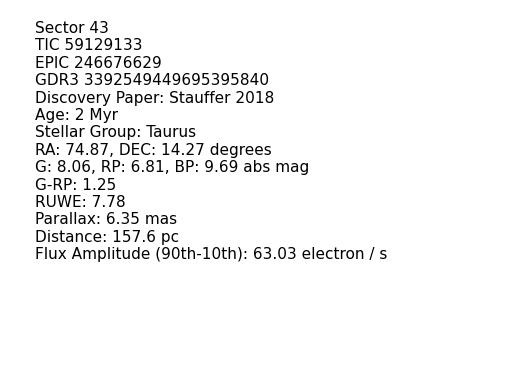

In [19]:
subgraph_text(mylc,'TIC-59129133-43-SPOC-120',gaiatable)

In [20]:
# def multiplot2(lc, infostring, gaiatable, period=None, bintime=None):
#     fig, axs = plt.subplot_mosaic([
#         ['A1', 'A2'],
#         ['A1', 'B2'],
#         ['C1', 'C2'],
#         ['D1', 'D2'],
#         ['E1', 'E1']
#     ], figsize=(16, 16))

#     if period==None:
#         period = lc.to_periodogram(maximum_period=5).period_at_max_power
#     if bintime==None:
#         bintime=u.Quantity(myperiod/200,u.s)
    
#     subgraph_phaselc(lc, ax=axs['A1'], period=period, bintime=bintime)
    
#     subgraph_pg(lc, ax = axs['C1'], period=period)

#     subgraph_2phaselc(lc, ax=axs['A2'], period=period, bintime=bintime)
#     subgraph_hphaselc(lc, ax=axs['B2'], period=period, bintime=bintime)

#     subgraph_rp(lc,ax=axs['C2'], period=period)

#     subgraph_CMD(infostring,gaiatable,ax=axs['D1'])

#     subgraph_text(lc, infostring,gaiatable,ax=axs['D2'])
    
#     subgraph_fulllc(lc, ax = axs['E1'])

#     return fig

In [119]:
fig=multiplot2(mylc, 'TIC-59129133-43-SPOC-120', gaiatable)
fig.savefig('TIC-59129133-43-SPOC-120.png',bbox_inches='tight')

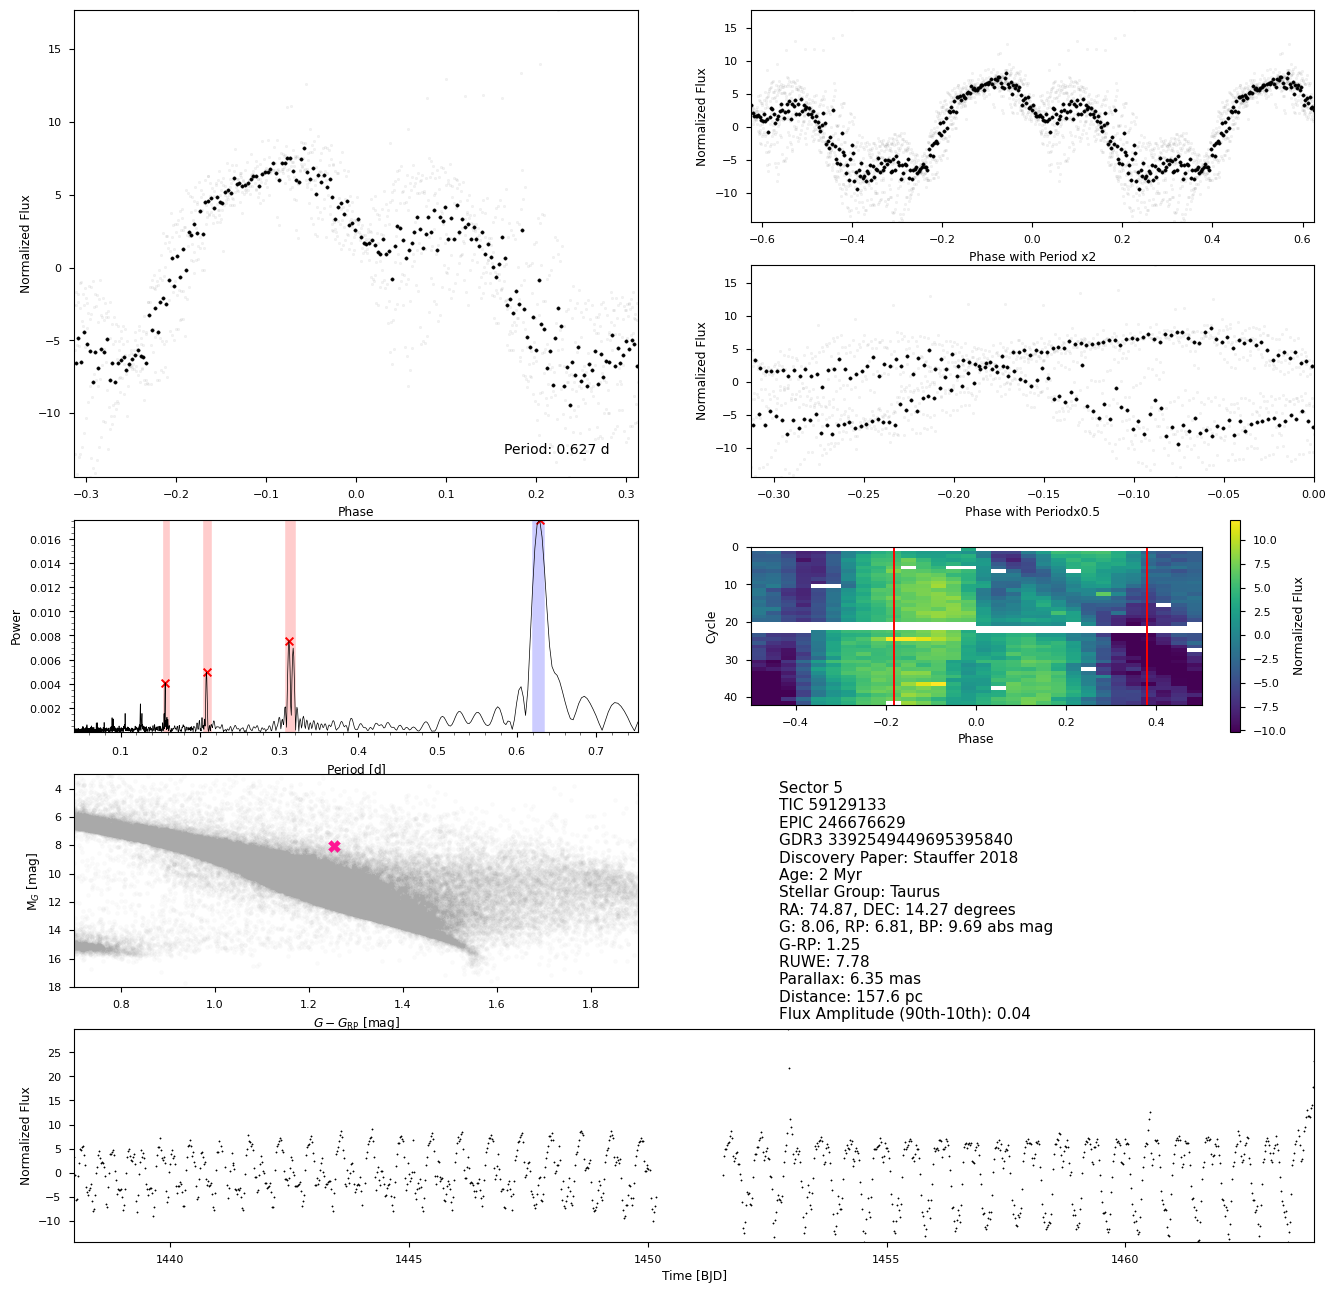

In [22]:
multiplot2(mylc2, 'TIC-59129133-5-FFI-30min', gaiatable)

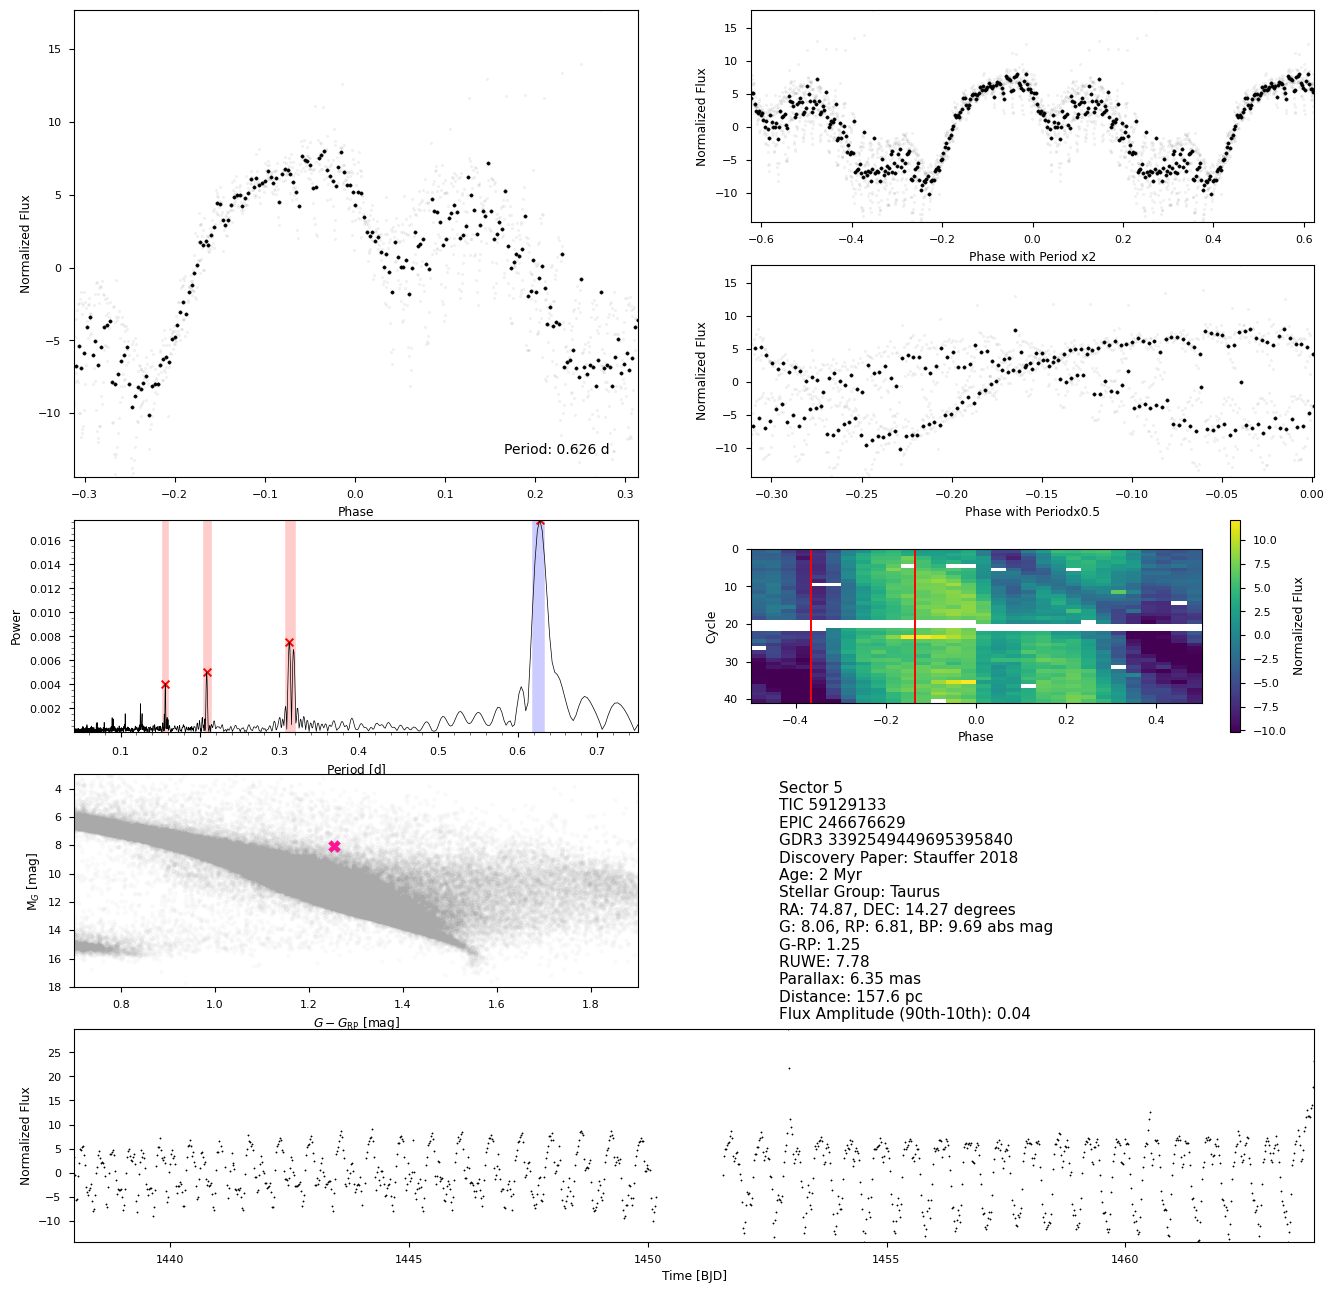

In [23]:
multiplot2(mylc2, 'TIC-59129133-5-FFI-30min', gaiatable,period=u.Quantity(0.626,u.d))

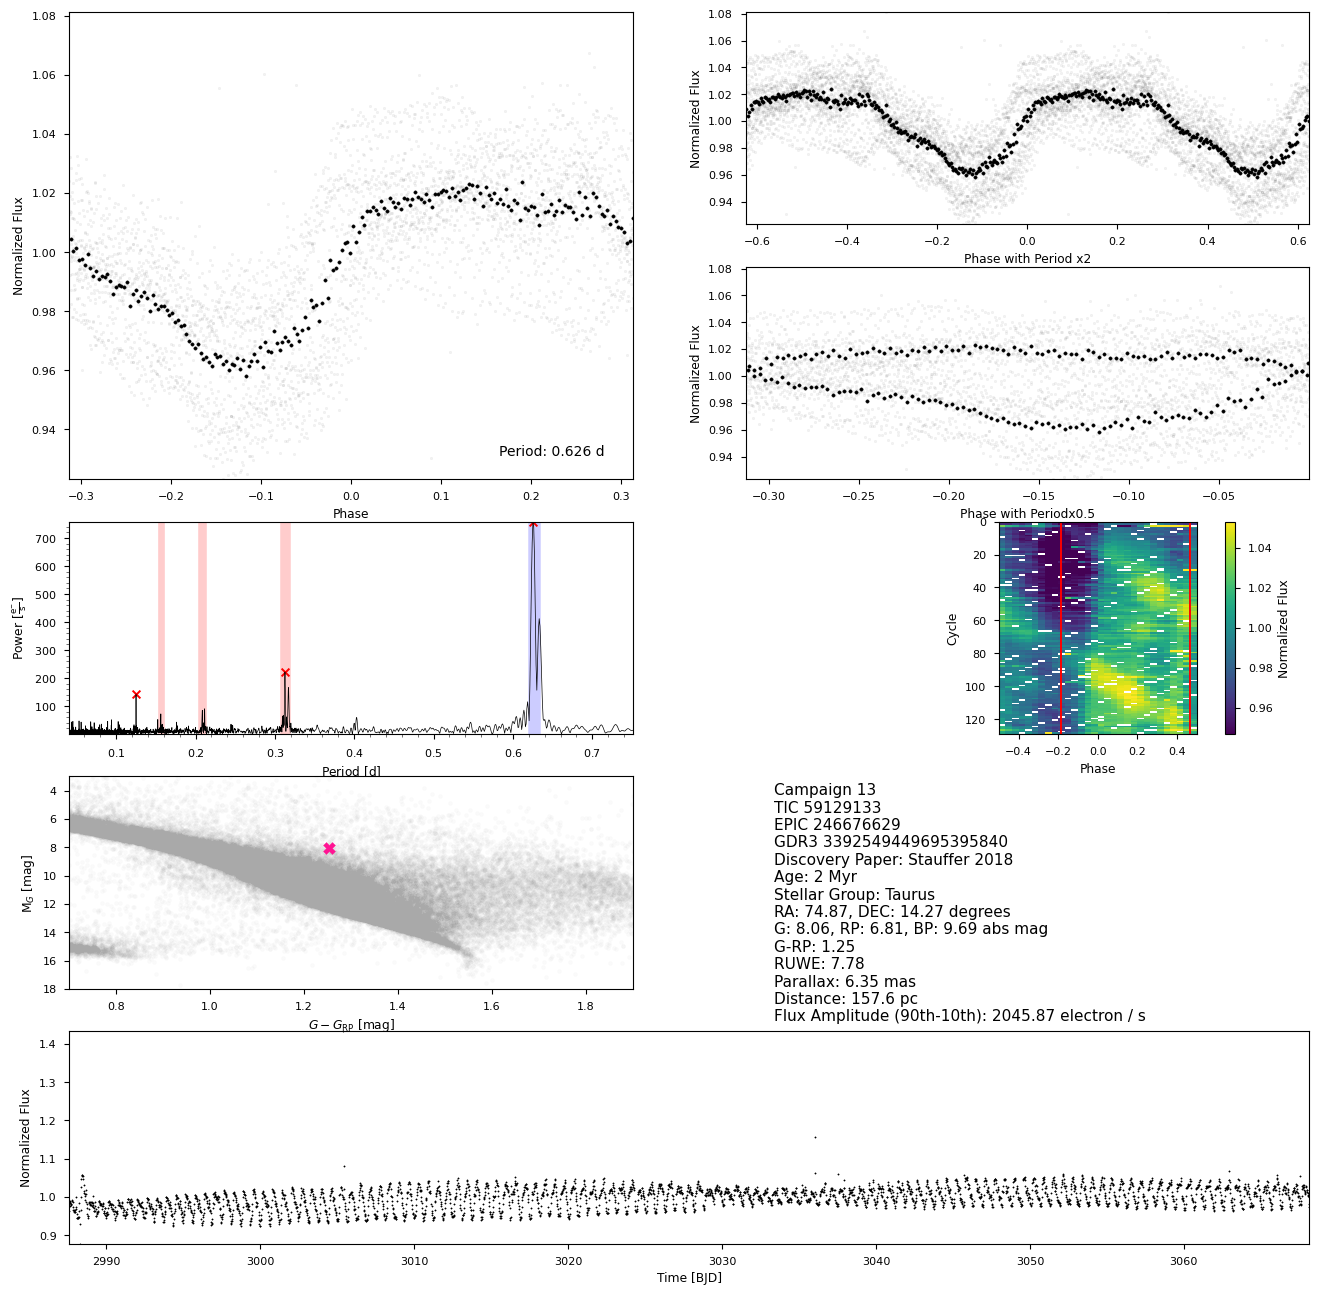

In [24]:
multiplot2(mylc3, 'EPIC-246676629-13-EVEREST-1800', gaiatable)

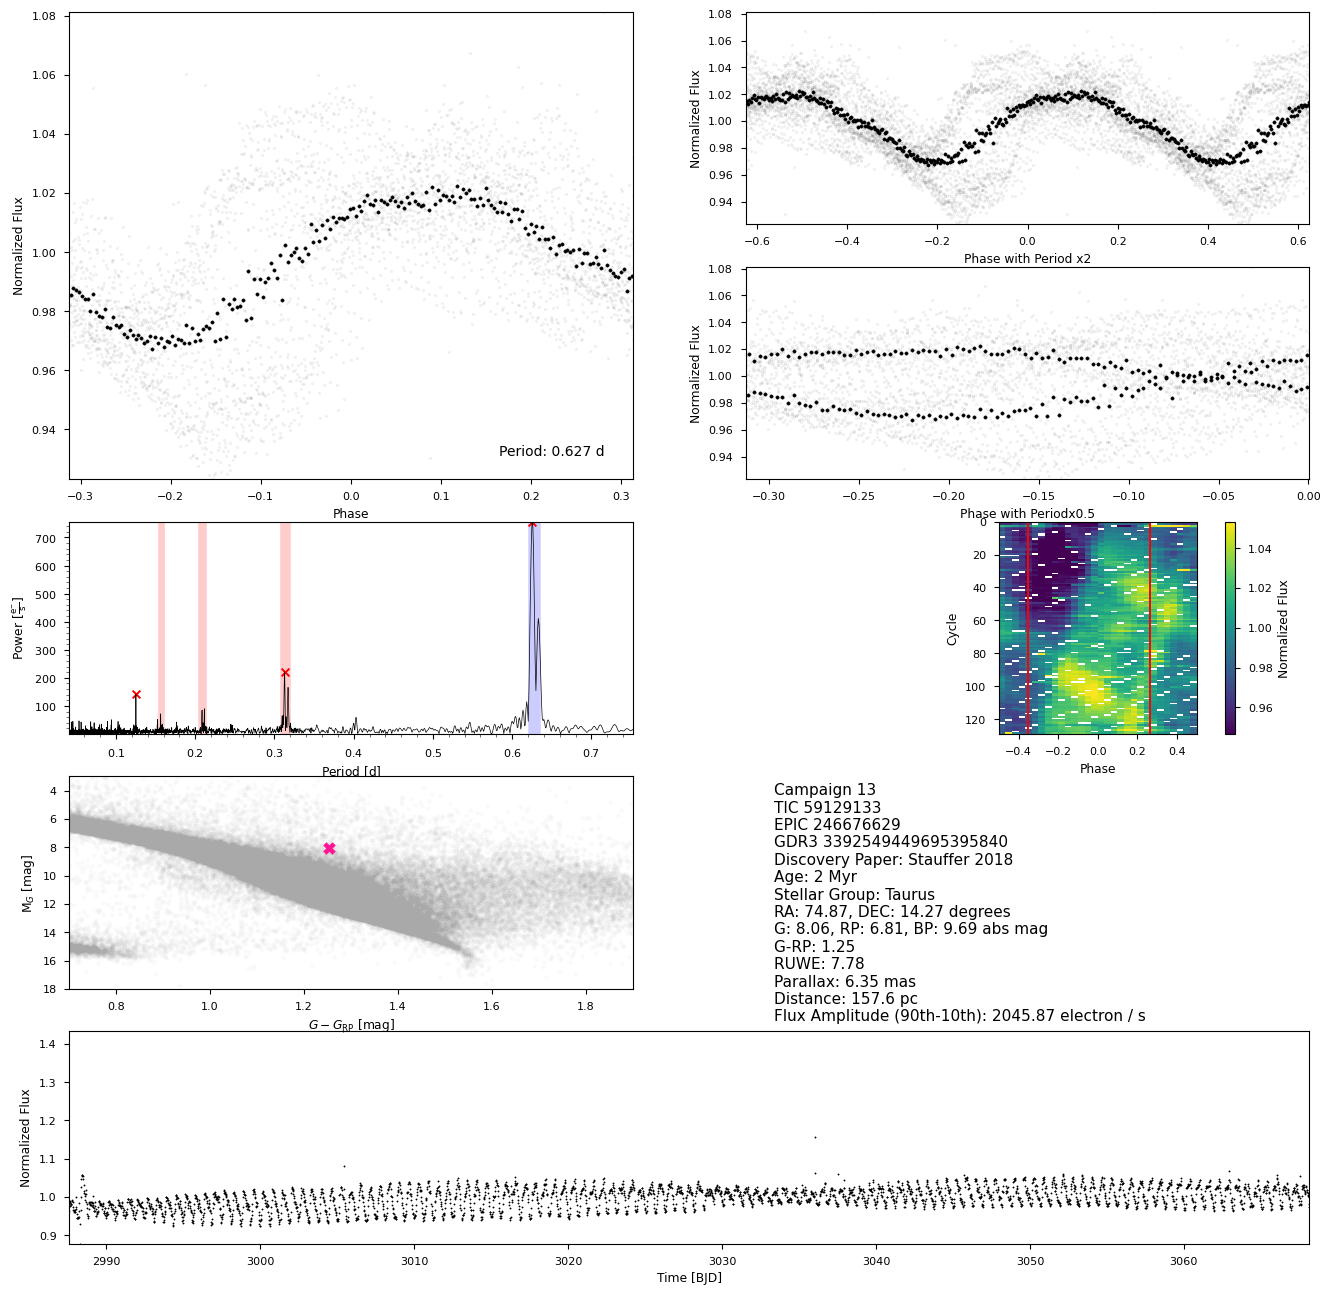

In [25]:
multiplot2(mylc3, 'EPIC-246676629-13-EVEREST-1800', gaiatable,period=u.Quantity(0.627,u.d))

In [26]:
#df=mylc3.to_pandas() # look for gaps of greater than 1 in cadenceno - found them

In [27]:
#df.reset_index(inplace=True)

In [28]:
#df['cadence_diff']=0

In [29]:
# for index, row in df.iterrows():
#     cadenceno=row['cadenceno']
#     nextcadenceno=df.at[index+1,'cadenceno']
#     difference=nextcadenceno-cadenceno
#     df.at[index,'cadence_diff']=difference

In [30]:
#df['cadence_diff'].value_counts()

In [31]:
mylc4=get_lc_string('EPIC-203692610-2-EVEREST-1800')
mylc5=get_lc_string('TIC-68131578-91-SPOC-120')

In [32]:
#multiplot2(mylc4, 'EPIC-203692610-2-EVEREST-1800', gaiatable,period=u.Quantity(1.821,u.d)) this one is horrible

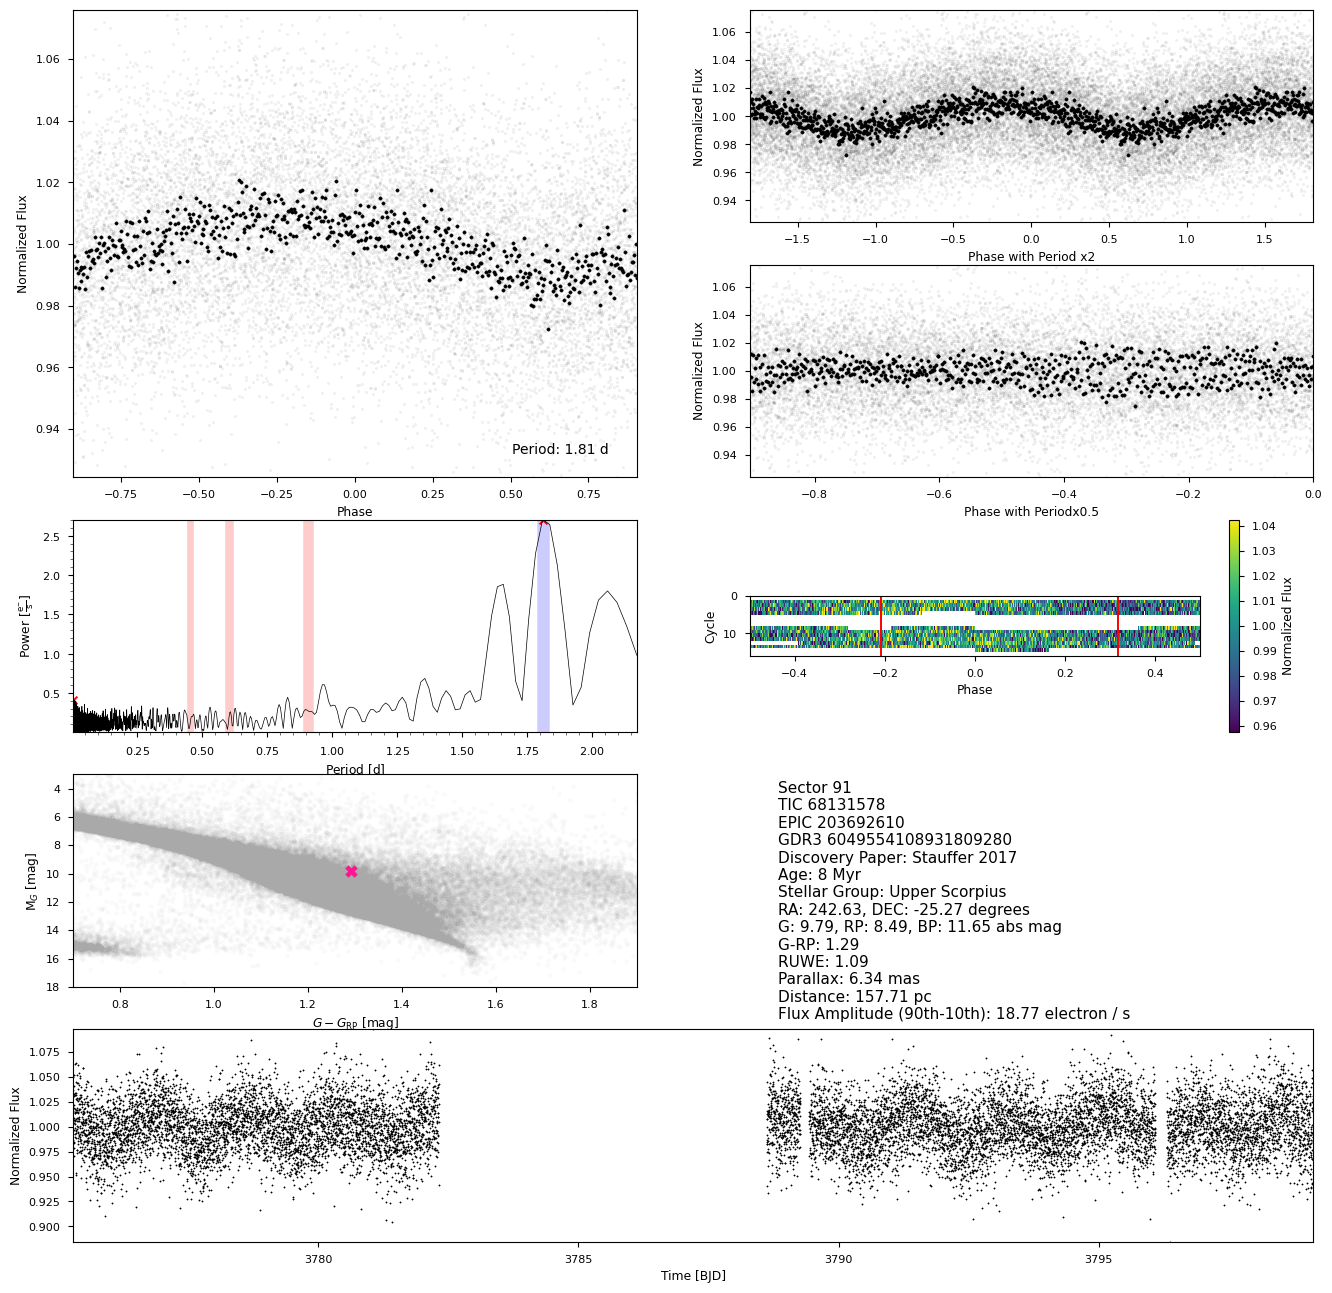

In [33]:
multiplot2(mylc5, 'TIC-68131578-91-SPOC-120', gaiatable)

In [34]:
mylc6=get_lc('EPIC',203692610 ,2, 'K2SFF', 1800)

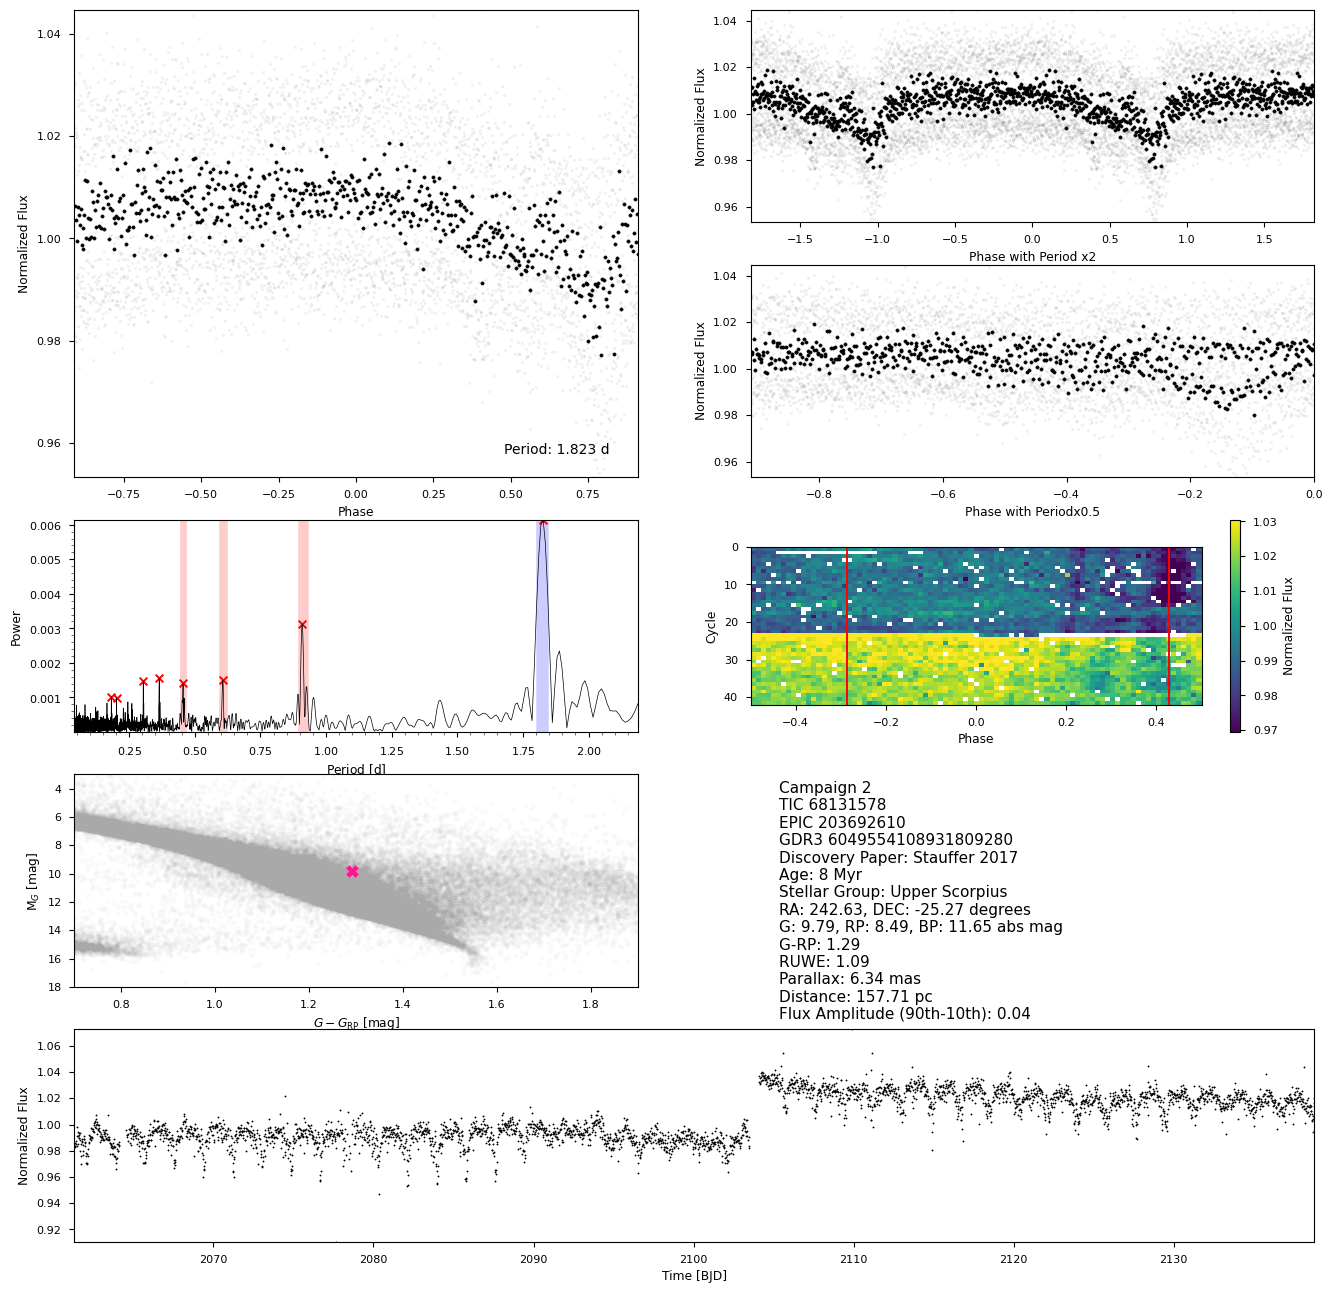

In [35]:
plt.close('all')
multiplot2(mylc6, 'EPIC-203692610-2-K2SFF-1800', gaiatable) #i think this one is normalized by default
plt.show()
#plt.savefig('EPIC-203692610-2-K2SFF-1800.png')

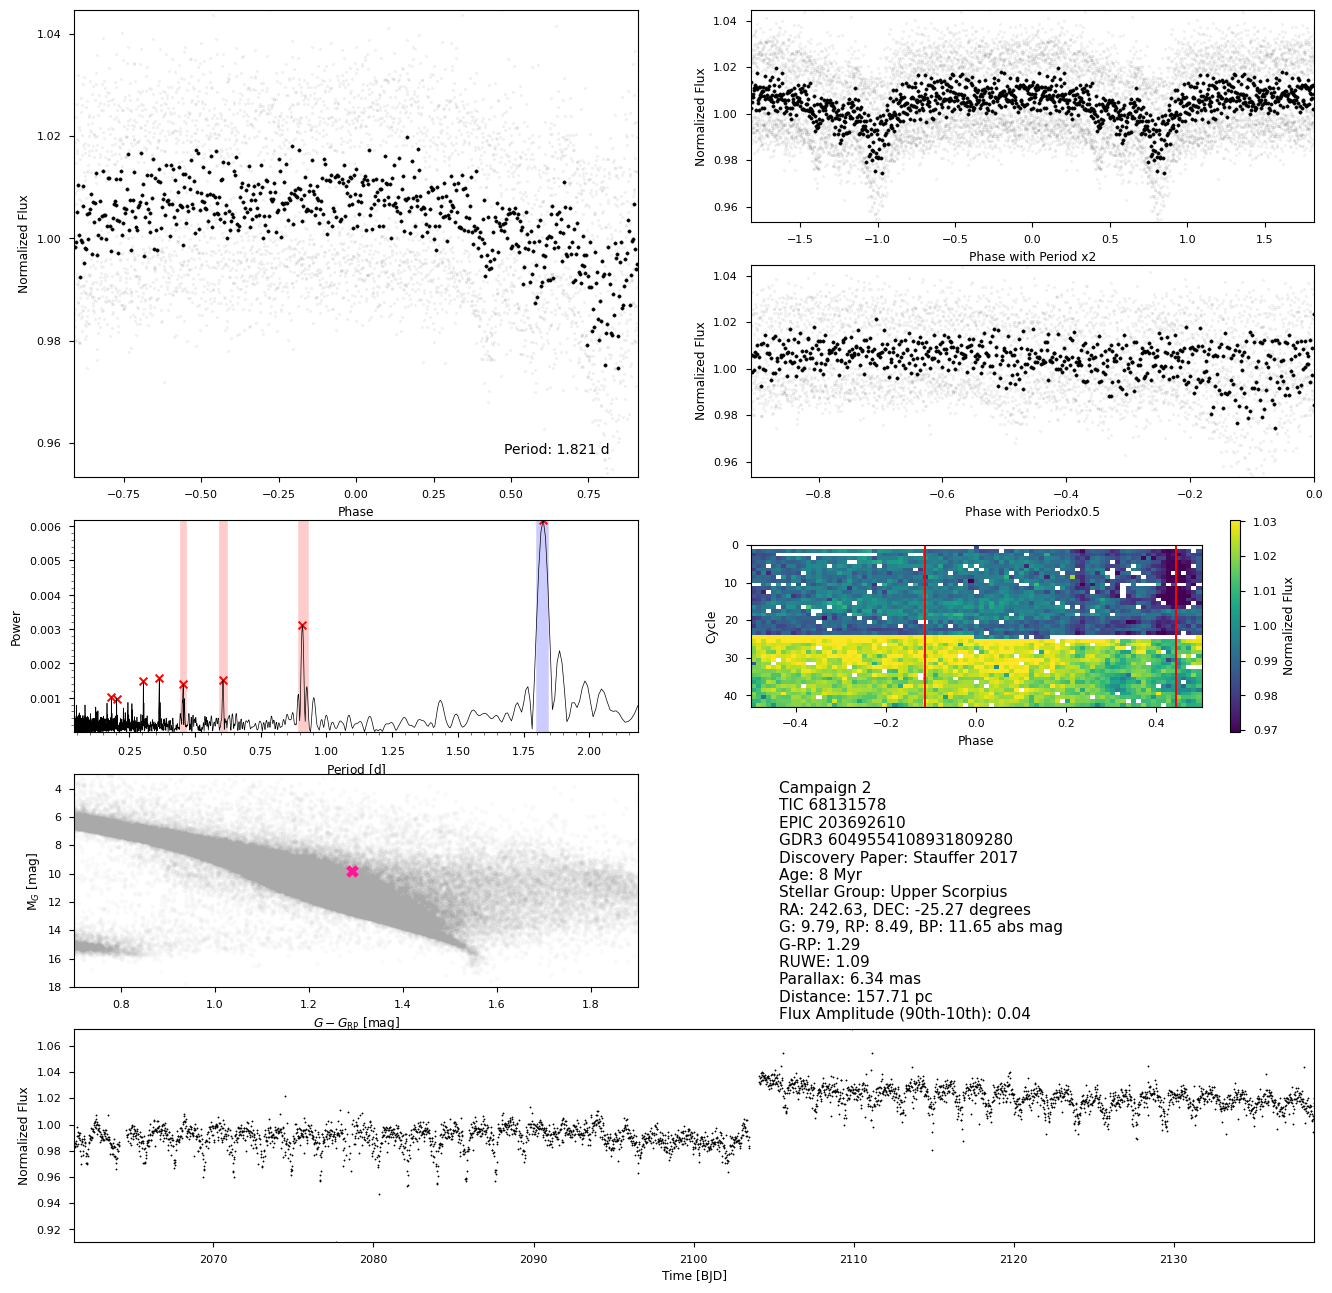

In [36]:
plt.close('all')
multiplot2(mylc6, 'EPIC-203692610-2-K2SFF-1800', gaiatable,period=u.Quantity(1.821,u.d))
plt.show()
#plt.savefig('EPIC-203692610-2-K2SFF-1800.png')

In [37]:
# def subgraph_CMD(infostring,gaiatable,ax=None):
#     #gaiatable must be a dataframe. load it in the multiplot fn
#     fig = None
    
#     parts=infostring.split("-")
#     id_type=parts[0]
#     starid=float(parts[1])
#     secorcamp=parts[2]
#     author=parts[3]
#     exptime=parts[4]
    
#     if ax == None:
#         fig, ax = plt.subplots()
        
#     ax.scatter(gaiatable.abs_g_rp,gaiatable.g_absmag,marker='.',c='darkgray',alpha=0.05)
#     if id_type=='TIC':
#         ax.scatter(gaiatable[gaiatable.TIC==starid].abs_g_rp,gaiatable[gaiatable.TIC==starid].g_absmag,marker='X',s=75,c='deeppink')
#     elif id_type=='EPIC':
#         ax.scatter(gaiatable[gaiatable.epic_id==starid].abs_g_rp,gaiatable[gaiatable.epic_id==starid].g_absmag,marker='X',s=75,c='deeppink')
#     ax.invert_yaxis()
#     ax.set_xlim(0.7,1.9)
#     ax.set_ylim(18,3)
#     ax.set_ylabel(r'M$_G$ [mag]')
#     ax.set_xlabel(r'$G-G_{\text{RP}}$ [mag]')

#     if fig != None:
#         return fig

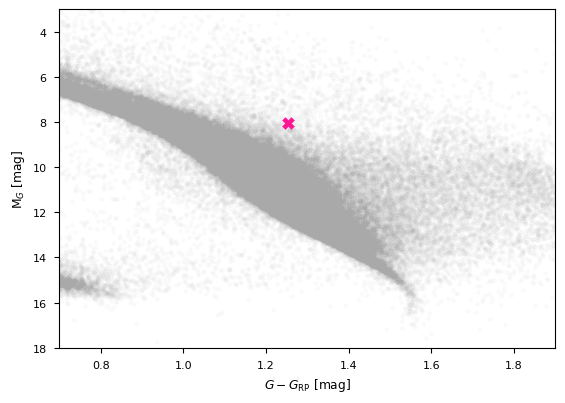

In [38]:
subgraph_CMD('TIC-59129133-43-SPOC-120',gaiatable)